## <p style="text-align: right;"> &#9989; Haoyan Lin</p>

# Day 18 Pre-class assignment: what does it mean for a model to "fit" the data?

<img src="https://www.originlab.com/images/WikiWeb/Curve_Surface_Fitting/Curve_Fitting_ApparentLinearFit.png" width=400px>

The purpose of this pre-class assignment is to start thinking about ways to compare models to data, and what it means for a model to "fit" the data.  We're going to do this by creating a dataset based on a simple model for a parabola, and then comparing parabolas with different shapes to that dataset.

## Goals for today's pre-class assignment 

</p>
1. Explore how to compute the "goodness of fit" for a model and corresponding data
2. Perform a "grid search" to identify the best bit parameters for a model given some data

## Assignment instructions

**This assignment is due by 11:59 p.m. the day before class** and should be uploaded into the appropriate "Pre-class assignments" dropbox folder in the Desire2Learn website. 

---
**Note**: Some of you may have completed a very similar notebook in CMSE 201. If that is the case, you should consider this notebook a nice opportunity to review some data fitting concepts!

Before we get started, we need to load various modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# You CAN set the random seed so we get reproducible results, but you don't have to.
# If you want that, uncomment the line below this.
#npr.seed(8675309)

## Step 1: Generate the data

In the cell below, we have given you a function ```my_model()``` that creates data points to define a model of a parabola.  The equation we're using is $y = A x^2 + B$, where A determines how wide the parabola is and B determines where the parabola intercepts the y-axis.  Negative values of A will result in a parabola that opens downward rather than upward; Negative values of B will have a negative intercept.  You can also specify the number of data points if you want, though you don't have to because it is a keyword argument with a default value.

We've added an noise term, sigma (often written as $\sigma$), which changes the y-values of the data points that are returned by adding or subtracting from them.  The amount that is added or subtracted is a Gaussian (or normal) distribution with a width of $\sigma$.

The function then returns the x values, the "real" y values, and the "noisy" y-values.  The noisy ones are the ones we're treating as our dataset!

In [2]:
def my_model(A,B,sigma=0.5,data_points=10):
    '''
    Creates a simple set of data points in a parabola that has 
    noise added in the y-direction.  The user can control the parabola
    properties (A and B) as well as the noise level and number of data
    points.  Returns x and (noisy) y values.
    '''
    x = np.linspace(-5,5,data_points)
    y = A*x**2 + B 
    y_noisy = y + np.random.normal(0.0,sigma,data_points)

    return x, y, y_noisy


The cell below has a simplified version of the function above, which takes in values of A, B, and some x-coordinates, which are intended to be the x-coordinates from the ```my_model()``` function.  This is the model that we're going to compare to our noisy data.

In [3]:
def est_model_vals(A,B,x):
    '''
    Given x-values and our MCMC code's estimates for A and B, this returns 
    estimated y values that we can compare to the actul data .
    '''
    return A*x**2 + B   

Now, we're going to actually create a dataset and plot it.  We've picked some values of A and B below that make a nice-looking parabola.  The noisy data is shown in the plot below in red, and the noise-free data is shown in blue.  The data also has error bars, which are ```sigma``` in length.



<ErrorbarContainer object of 3 artists>

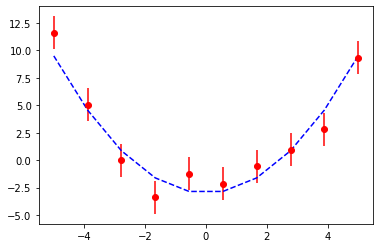

In [60]:
'''
---------------- USER SETS THESE! ----------------
 A_user = parabola width
 B_user = y-axis intercept
 sigma = error added to the y-values (the noise)
 data_points = number of data points we want to use
'''

A_user = 0.5
B_user = -3
sigma = 1.5
data_points=10

# now we're going to generate a model and create artificial "data" with some error in it.
x_data, y_model, y_data = my_model(A_user,B_user,sigma,data_points)

# plot the "data" so we can see what's going on!
# Note: if you make A too big, it may be hard to see the errors.
plt.plot(x_data,y_model,'b--')
plt.errorbar(x_data, y_data, yerr=sigma, fmt='ro')


**Question for you:** Experiment with different values of A, B, and sigma in the cell above.  What happens when you vary those quantities?  (Particularly sigma.)

With the value of sigma is increasing, the error will increase as following. The plot just like be zoomed. And the original plot reflect the whole curve.

**BEFORE YOU GO FURTHER**, change your values of A_user, B_user, and sigma back to 0.5, -3, and 1.5, respectively, and rerun the code above.  We're going to use that below.

# Step 2 - thinking about "fit" of models with data

How do we decide how good of a "fit" a model is to a given dataset?  In other words, how do we decide if a model accurately represents that data?  Or, if we have multiple models that we're comparing to a dataset, how do we quantitatively evaluate which one is the "best" fit?

There are many quantitative ways to do this, and one of the most common methods for a  model like we're using is called the ["reduced chi-squared"](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic) method.  The equation that describes this is as follows:

$$ \chi_R^2 = \frac{\sum_i (y_{data,i} - y_{model,i})^2}{N_{pts} \sum_i 2 \sigma_i^2} $$

In this equation, $\chi_R^2$ is computed as follows.  We take the sum over all data points $i$ (the sum is written as $\sum_i$) of the square of the difference of the data at each point, $y_{data,i}$, and the value of the model at that point, $y_{model,i}$). Then, we divide it by the number of data points, $N_{pts}$, times the sum of two times the square of our estimates of the error, $\sigma_i$, associated with each data point.  We take the square of the terms so that differences in both the positive and negative values are counted equally (in other words, it doesn't matter if the model is bigger than the data value at a given point, or vice versa - it's just the distance). **What this means** is that $\chi_R^2$ gets *bigger* when the model and the data *disagree more* on average, and $\chi_R^2$ also gets *bigger* when the assumed error is *smaller*, since the error is in the denominator. **A smaller $\chi_R^2$ thus suggests a better fit between model and data!**

We can implement this in code with the following function, which takes in an array of data values, an array of model values, and an estimate of the error associated with each data point (the error can either be an array or a scalar value - Numpy is clever enough to know the difference).  It then returns the reduced chi-squared value, $\chi_R^2$. **Review the function and make sure you agree that it is the same as the equation above.**

In [61]:
def chi_squared_error(ydata,ymodel,error):
    '''
    Takes in the observed data, our model's estimated y-values 
    for the model, and our estimate for the errors in the data.
    
    Returns sum-of-squares error (chi-squared error) 
    '''
    
    return ((ydata-ymodel)**2/(2*error**2)).sum()/(ydata.size)


We can then calculate the reduced chi-squared between our model and dataset as follows:

In [62]:
chi_squared = chi_squared_error(y_data,y_model,sigma)

print("Our reduced chi-squared value is:", chi_squared)

Our reduced chi-squared value is: 0.3556494184439659


**Question for you:** Now try changing the `ydata` array (add and subtract numbers, or multiply it by values) and change the error (`sigma`) term, and see how it affects the chi-squared value.  In general, what do you observe? (Note: don't change the function that produces the data array, just change the actual array values)

When the error /sigma increase from 1.5 to 10 and then 100, the chi_squared value also was affected. The chi_squared changed from 0.524194868509004 to 0.5071668639398013 and then 0.44032495340067557. I can notice, every time we run again, alough I did not change the value of sigma, the chi_squared value also changed.


# Step 3 - Searching for the "best" model for a given dataset

Now we're going to pretend that we don't know the "best" values for A and B in our model, and we'll use a simple method to find them.  This is what is often called a **"grid search"** - we pick a range of A and B values, a step in both A and B ($\Delta A$ and $\Delta B$), and then step through A and B values and calculate the $\chi_R^2$ value of each pair of values.  The values with the smallest $\chi_R^2$ are the ones that are determined to be the best-fit to the data!

**Your instructions:** Given a grid of A and B values, step through A and B and calculate the error for each value and save it so that we can plot it later.  We'll get you started by providing a Numpy meshgrid of A and B values, as well as an array where you can store errors.

**Before you start:** Make sure that the values of A, B, and sigma from above are set to 0.5, -3, and 1.5, respectively.  This will make sure that the "real" value of the model is within the region we're looking at!

In [63]:
'''
The variables below control the range of A and B values, as well as the step that we 
take in the A and B direction.  If Astart = -4, Aend = 4, and deltaA = 2, that means
we'll test A = -4, -2, 0, 2, 4 (and so on).  As a result, smaller values of deltaA 
and deltaB mean a finer grid, but also will take longer.  We assume that Astart and Bstart
are smaller than their corresponding end values, by the way!
'''
Astart = -4
Aend = 4
deltaA = 0.1

Bstart = -10
Bend = 8
deltaB = 0.2

'''
We use Numpy's meshgrid method to make two 2D arrays of A and B values that we
can step through, Avalues and Bvalues. Note that we use a special version of the
meshgrid function, "mgrid". However, it does the same thing as meshgrid, which
you have likely seen before. If you're not sure what the resulting arrays
look like, you should print them out to understand what meshgrid is doing.

'''
Avalues, Bvalues = np.mgrid[Astart:Aend:deltaA, Bstart:Bend:deltaB]

'''
We then make a grid to store our chi-squared values, which is the same size as 
our grids of A and B values
'''
chisquared_grid = np.zeros_like(Avalues)

'''
PUT YOUR CODE BELOW.  Loop over the arrays of A and B values and calculate the errors.
You should store the error values in the empty array of chi-squared values created above.

'''



'\nPUT YOUR CODE BELOW.  Loop over the arrays of A and B values and calculate the errors.\nYou should store the error values in the empty array of chi-squared values created above.\n\n'

In [64]:
#code here

for i in range(chisquared_grid.shape[0]):
    for j in range(chisquared_grid.shape[1]):
        this_model = est_model_vals(Avalues[i,j], Bvalues[i,j], x_data)
        chisquared_grid[i,j] = chi_squared_error(this_model, y_data, sigma)
print("min, max error values are:", chisquared_grid.min(), chisquared_grid.max())

min, max error values are: 0.35075864367314236 987.7537873306883


Once you've filled your array of values, we can make a plot of the reduced chi-squared values.  It's often better to make a plot of the log of the values, because they vary quite a bit and plotting the log values helps us see what's going on more easily.  The code below will make a plot of the log of the chi-squared error, with smaller values of chi-squared (better fits) corresponding to lighter colors, and larger values (worse fits) corresponding to darker colors.  We also plot the "real" value of the data with a cyan circle.


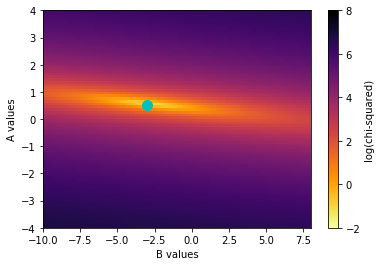

In [65]:
# take the log of chi-squared
log_chisquared_grid = np.log(chisquared_grid)

# make the log of chi-squared, with a lot of optional arguments to make
# everything look nice and show the correct values. Look at the documentation
# for plt.imshow() to see what all of these mean!
plt.imshow(log_chisquared_grid,interpolation='none',
                    extent=(Bstart,Bend,Astart,Aend),aspect='auto',
                    origin='lower',cmap='inferno_r')
plt.ylabel("A values")
plt.xlabel("B values")
cb = plt.colorbar()
cb.set_label("log(chi-squared)")
plt.clim(-2,8)

# plot a cyan dot in the user-defined values.
plt.plot(B_user,A_user,'co',markersize=10)


**Question:** Vary the model values for A and B, as well as sigma.  When you change these, how does the plot above change?  In particular, what happens as you make sigma larger and smaller, and what do you think that means?  Is the true value of the model parameters always in (or at least near) the brightest cell?

The blue point position will change with the changing of A and B value.  With thw value of sigma become larger, the plot turns more orange. And lowering the sigma value, the plot turns more dark blue. Yes, the true value of the model parameters is always in the brightest cell.

# Step 4 - thinking about fitting models to data.

This type of algorithm is very useful in some circumstances, but has limitations.  What do you think will happen if you have a model with many parameters?  Do you think that this grid-based method will work?  Why or why not?

1. Having such a large parameters can lead to overfitting. They work very well despite these potential overfitting problems. 
2. I think this grid-based method works. The grid-based approach quantifies the object space as a finite number of cells and then performs the required operations on the quantized space. The main advantage of the grid-based approach is fast processing time, which depends on the number of cells per dimension in the quantized space.

----
# Assignment wrap-up

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [66]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse202-pc-survey" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

---------
### Congratulations, you're done with your pre-class assignment!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for today's dropbox (Don't forget to add your name in the first cell).

&#169; Copyright 2018,  Michigan State University Board of Trustees